## José Paulo de Almeida Diniz - 1510910
## Lucas H. G. C. França - 1811457

## Instruções Gerais
* Identifiquem no início do arquivo os integrantes do grupo (nome e matrícula)
* Por limitações do moodle, o nome do arquivo submetido não pode ter caracteres acentuados ou com cedilha
* Apenas um dos integrantes do grupo deve fazer a submissão no moodle
* Certifiquem-se de que o arquivo pode ser executado diretamente e sem dependências externas (Kernel > Restart & Run All)

## Enunciado do Trabalho

Tomem como base os dados sobre desenvolvimento humano disponíveis em: http://hdr.undp.org/en/data. 
A partir de dados de pobreza e de educação, criem alguns modelos de regressão linear (variando as _features_) para tentar prever a população carcerária de cada país. Avaliem os modelos e indique qual foi o melhor.

In [1]:
import requests, zipfile, io
import pandas as pd
import numpy as np

# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# machine learning libraries and functions
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, cross_val_predict
import sklearn.metrics

In [2]:
prisonlistfilepath = 'in.data/worldprisonpopulationlist.csv'
prisonlistdf = pd.read_csv(prisonlistfilepath, encoding = "ISO8859-1", sep = ';')
print(prisonlistdf.shape)
print(prisonlistdf.columns)
prisonlistdf.head()

(203, 18)
Index(['Country', '2002', '2003', '2004', '2005', '2006', '2007', '2008',
       '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017',
       '2018'],
      dtype='object')


,Country,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
0,Afghanistan,NaN,NaN,NaN,NaN,NaN,30.0,NaN,NaN,62.0,NaN,76.0,NaN,74.0,NaN,NaN,88.0,NaN
1,Albania,NaN,105.0,NaN,111.0,NaN,NaN,159.0,141.0,NaN,NaN,NaN,158.0,NaN,189.0,NaN,NaN,188.0
2,Algeria,NaN,NaN,121.0,127.0,NaN,158.0,NaN,NaN,164.0,NaN,NaN,162.0,NaN,NaN,NaN,146.0,NaN
3,American Samoa,243.0,301.0,446.0,NaN,NaN,410.0,198.0,NaN,NaN,240.0,NaN,382.0,NaN,NaN,NaN,345.0,NaN
4,Andorra,83.0,90.0,NaN,NaN,37.0,NaN,NaN,NaN,73.0,NaN,NaN,38.0,72.0,NaN,NaN,NaN,69.0


In [3]:
hdifilepath = 'in.data/Human development index (HDI).csv'
hdidf = pd.read_csv(hdifilepath, encoding = "ISO8859-1", sep = ',')
print(hdidf.shape)
print(hdidf.columns)
hdidf.head()

(189, 30)
Index(['HDI Rank (2017)', 'Country', '1990', '1991', '1992', '1993', '1994',
       '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003',
       '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012',
       '2013', '2014', '2015', '2016', '2017'],
      dtype='object')


,HDI Rank (2017),Country,1990,1991,1992,1993,1994,1995,1996,1997,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,168,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.437,0.453,0.463,0.471,0.482,0.487,0.491,0.493,0.494,0.498
1,68,Albania,0.645,0.626,0.610,0.613,0.619,0.632,0.641,0.641,...,0.724,0.729,0.741,0.752,0.767,0.771,0.773,0.776,0.782,0.785
2,85,Algeria,0.577,0.581,0.587,0.591,0.595,0.600,0.608,0.617,...,0.709,0.719,0.729,0.736,0.740,0.745,0.747,0.749,0.753,0.754
3,35,Andorra,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.831,0.830,0.828,0.827,0.849,0.850,0.853,0.854,0.856,0.858
4,147,Angola,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.502,0.522,0.520,0.535,0.543,0.554,0.564,0.572,0.577,0.581


In [4]:
unemploymentfilepath = 'in.data/Unemployment, total (% of labour force).csv'
unemploymentdf = pd.read_csv(unemploymentfilepath, encoding = "ISO8859-1", sep = ',')
print(unemploymentdf.shape)
print(unemploymentdf.columns)
unemploymentdf.head()

(182, 14)
Index(['HDI Rank (2017)', 'Country', '1991', '1995', '2000', '2005', '2010',
       '2011', '2012', '2013', '2014', '2015', '2016', '2017'],
      dtype='object')


,HDI Rank (2017),Country,1991,1995,2000,2005,2010,2011,2012,2013,2014,2015,2016,2017
0,168,Afghanistan,12.0,8.7,11.2,8.5,7.8,8.2,7.9,8.5,8.7,8.9,8.8,8.8
1,68,Albania,22.3,23.9,22.7,17.5,14.2,14.0,13.4,15.6,17.5,17.1,15.2,13.9
2,85,Algeria,20.6,27.9,29.8,15.3,10.0,10.0,11.0,9.8,10.6,11.2,10.2,10.0
3,147,Angola,23.7,23.9,23.7,21.4,9.9,7.4,7.4,7.3,7.3,7.3,7.7,8.2
4,47,Argentina,5.6,18.8,15.0,11.5,7.4,7.1,7.3,6.6,7.0,6.9,8.4,8.7


In [5]:
chifilepath = 'in.data/Coefficient of Human Inequality.csv'
chidf = pd.read_csv(chifilepath, encoding = "ISO8859-1", sep = ',')
print(chidf.shape)
print(chidf.columns)
chidf.head()

(165, 10)
Index(['HDI Rank (2017)', 'Country', '2010', '2011', '2012', '2013', '2014',
       '2015', '2016', '2017'],
      dtype='object')


,HDI Rank (2017),Country,2010,2011,2012,2013,2014,2015,2016,2017
0,168.0,Afghanistan,30.0,30.0,30.4,28.2,28.2,NaN,NaN,NaN
1,68.0,Albania,12.7,13.8,13.8,13.4,13.4,13.4,12.2,10.0
2,85.0,Algeria,20.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,147.0,Angola,38.8,43.6,43.6,36.6,36.6,32.3,32.3,NaN
4,47.0,Argentina,19.0,18.7,18.7,15.3,14.6,15.2,14.0,13.9


In [6]:
educationfilepath = 'in.data/Education Index.csv'
educationdf = pd.read_csv(educationfilepath, encoding = "ISO8859-1", sep = ',')
print(educationdf.shape)
print(educationdf.columns)
educationdf.head()

(190, 30)
Index(['HDI Rank (2017)', 'Country', '1990', '1991', '1992', '1993', '1994',
       '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003',
       '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012',
       '2013', '2014', '2015', '2016', '2017'],
      dtype='object')


,HDI Rank (2017),Country,1990,1991,1992,1993,1994,1995,1996,1997,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,168.0,Afghanistan,0.122,0.133,0.145,0.156,0.168,0.179,0.190,0.202,...,0.347,0.359,0.371,0.382,0.390,0.398,0.406,0.410,0.410,0.415
1,68.0,Albania,0.584,0.589,0.558,0.543,0.542,0.551,0.558,0.571,...,0.646,0.652,0.673,0.693,0.730,0.732,0.733,0.733,0.742,0.745
2,85.0,Algeria,0.385,0.395,0.405,0.414,0.424,0.431,0.443,0.458,...,0.588,0.608,0.626,0.644,0.652,0.660,0.661,0.662,0.663,0.664
3,35.0,Andorra,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.661,0.661,0.662,0.663,0.715,0.715,0.716,0.715,0.714,0.714
4,147.0,Angola,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.390,0.404,0.398,0.423,0.435,0.447,0.460,0.472,0.487,0.498


In [7]:
incomefilepath = 'in.data/Income Index.csv'
incomedf = pd.read_csv(incomefilepath, encoding = "ISO8859-1", sep = ',')
print(incomedf.shape)
print(incomedf.columns)
incomedf.head()

(192, 30)
Index(['HDI Rank (2017)', 'Country', '1990', '1991', '1992', '1993', '1994',
       '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003',
       '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012',
       '2013', '2014', '2015', '2016', '2017'],
      dtype='object')


,HDI Rank (2017),Country,1990,1991,1992,1993,1994,1995,1996,1997,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,168,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.388,0.413,0.421,0.426,0.442,0.443,0.441,0.439,0.438,0.439
1,68,Albania,0.575,0.523,0.510,0.531,0.547,0.570,0.585,0.568,...,0.683,0.686,0.693,0.699,0.700,0.705,0.707,0.711,0.717,0.722
2,85,Algeria,0.694,0.686,0.686,0.681,0.676,0.677,0.680,0.680,...,0.730,0.730,0.734,0.734,0.734,0.734,0.737,0.739,0.744,0.744
3,35,Andorra,0.904,0.902,0.897,0.891,0.890,0.891,0.897,0.910,...,0.931,0.924,0.916,0.910,0.910,0.914,0.920,0.924,0.927,0.931
4,147,Angola,0.456,0.453,0.450,0.403,0.363,0.443,0.468,0.485,...,0.583,0.613,0.603,0.601,0.602,0.613,0.620,0.625,0.617,0.613


In [8]:
years_in_schoolfilepath = 'in.data/Mean years of schooling (years).csv'
years_in_schooldf = pd.read_csv(years_in_schoolfilepath, encoding = "ISO8859-1", sep = ',')
print(years_in_schooldf.shape)
print(years_in_schooldf.columns)
years_in_schooldf.head()

(202, 31)
Index(['HDI Rank (2017)', 'Country', '1990', '1991', '1992', '1993', '1994',
       '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003',
       '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012',
       '2013', '2014', '2015', '2016', '2017', 'Unnamed: 30'],
      dtype='object')


,HDI Rank (2017),Country,1990,1991,1992,1993,1994,1995,1996,1997,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,Unnamed: 30
0,168,Afghanistan,1.5,1.6,1.6,1.7,1.8,1.9,1.9,2.0,...,3.1,3.2,3.3,3.4,3.5,3.5,3.6,3.6,3.8,"a,b"
1,68,Albania,7.8,7.8,7.8,7.8,7.8,8.0,8.2,8.3,...,9.3,9.3,9.3,9.6,9.7,9.7,9.7,10.0,10.0,a
2,85,Algeria,3.6,3.8,4.0,4.3,4.5,4.7,5.0,5.2,...,6.9,7.1,7.4,7.6,7.8,7.9,7.9,8.0,8.0,"a,c"
3,35,Andorra,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10.1,10.1,10.2,10.2,10.2,10.2,10.2,10.2,10.2,a
4,147,Angola,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.7,4.7,4.7,4.8,4.9,4.9,5.0,5.1,5.1,"a,d"


In [9]:
mpifilepath = 'in.data/Multidimensional poverty index (MPI).csv'
mpidf = pd.read_csv(mpifilepath, encoding = "ISO8859-1", sep = ',')
print(mpidf.shape)
print(mpidf.columns)
mpidf.head()

(165, 10)
Index(['HDI Rank (2017)', 'Country', '2010', '2011', '2012', '2013', '2014',
       '2015', '2016', '2017'],
      dtype='object')


,HDI Rank (2017),Country,2010,2011,2012,2013,2014,2015,2016,2017
0,168.0,Afghanistan,NaN,NaN,NaN,30.0,30.0,30.4,28.2,28.2
1,68.0,Albania,12.7,13.8,13.8,13.4,13.4,13.4,12.2,10.0
2,85.0,Algeria,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.1
3,147.0,Angola,38.8,NaN,43.6,43.6,36.6,36.6,32.3,32.3
4,47.0,Argentina,19.0,18.7,18.7,15.3,14.6,15.2,14.0,13.9


In [10]:
years = [col for col in prisonlistdf.columns if col != 'Country']
#years
countries = np.array(prisonlistdf['Country'])
#countries
dataframes = [hdidf, unemploymentdf, chidf, educationdf, incomedf, years_in_schooldf, mpidf, prisonlistdf]
#dataframes
new_columns = ['HDI', 'Unemployment', 'Inequality', 'Education', 'Income', 'SchoolYears', 'Poverty', 'PrisonPop']
#new_columns
for df in dataframes:
    df.set_index('Country', inplace=True)

In [11]:
new_data_frame = []
for y in years:
    for c in countries:
        row = []
        for i in range(len(dataframes)):
            if (y in dataframes[i].columns and c in dataframes[i].index):
                if (pd.isna(dataframes[i].loc[c][y])):
                    row.append('NaN')
                else: row.append(dataframes[i].loc[c][y])
            else: row.append('NaN')
        if('NaN' not in row):
            #print(row)
            new_data_frame.append(row)
new_data_frame = pd.DataFrame(new_data_frame, columns = new_columns)

In [12]:
new_data_frame.info()
new_data_frame.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 8 columns):
HDI             303 non-null float64
Unemployment    303 non-null float64
Inequality      303 non-null float64
Education       303 non-null float64
Income          303 non-null float64
SchoolYears     303 non-null float64
Poverty         303 non-null float64
PrisonPop       303 non-null float64
dtypes: float64(8)
memory usage: 19.0 KB


,HDI,Unemployment,Inequality,Education,Income,SchoolYears,Poverty,PrisonPop
0,0.728,19.0,10.9,0.731,0.643,11.1,10.9,156.0
1,0.923,5.2,7.7,0.913,0.905,12.4,7.7,133.0
2,0.895,4.8,7.3,0.837,0.918,11.8,7.3,103.0
3,0.789,14.3,14.0,0.716,0.815,10.9,14.0,382.0
4,0.545,3.4,28.3,0.425,0.495,4.9,28.3,42.0


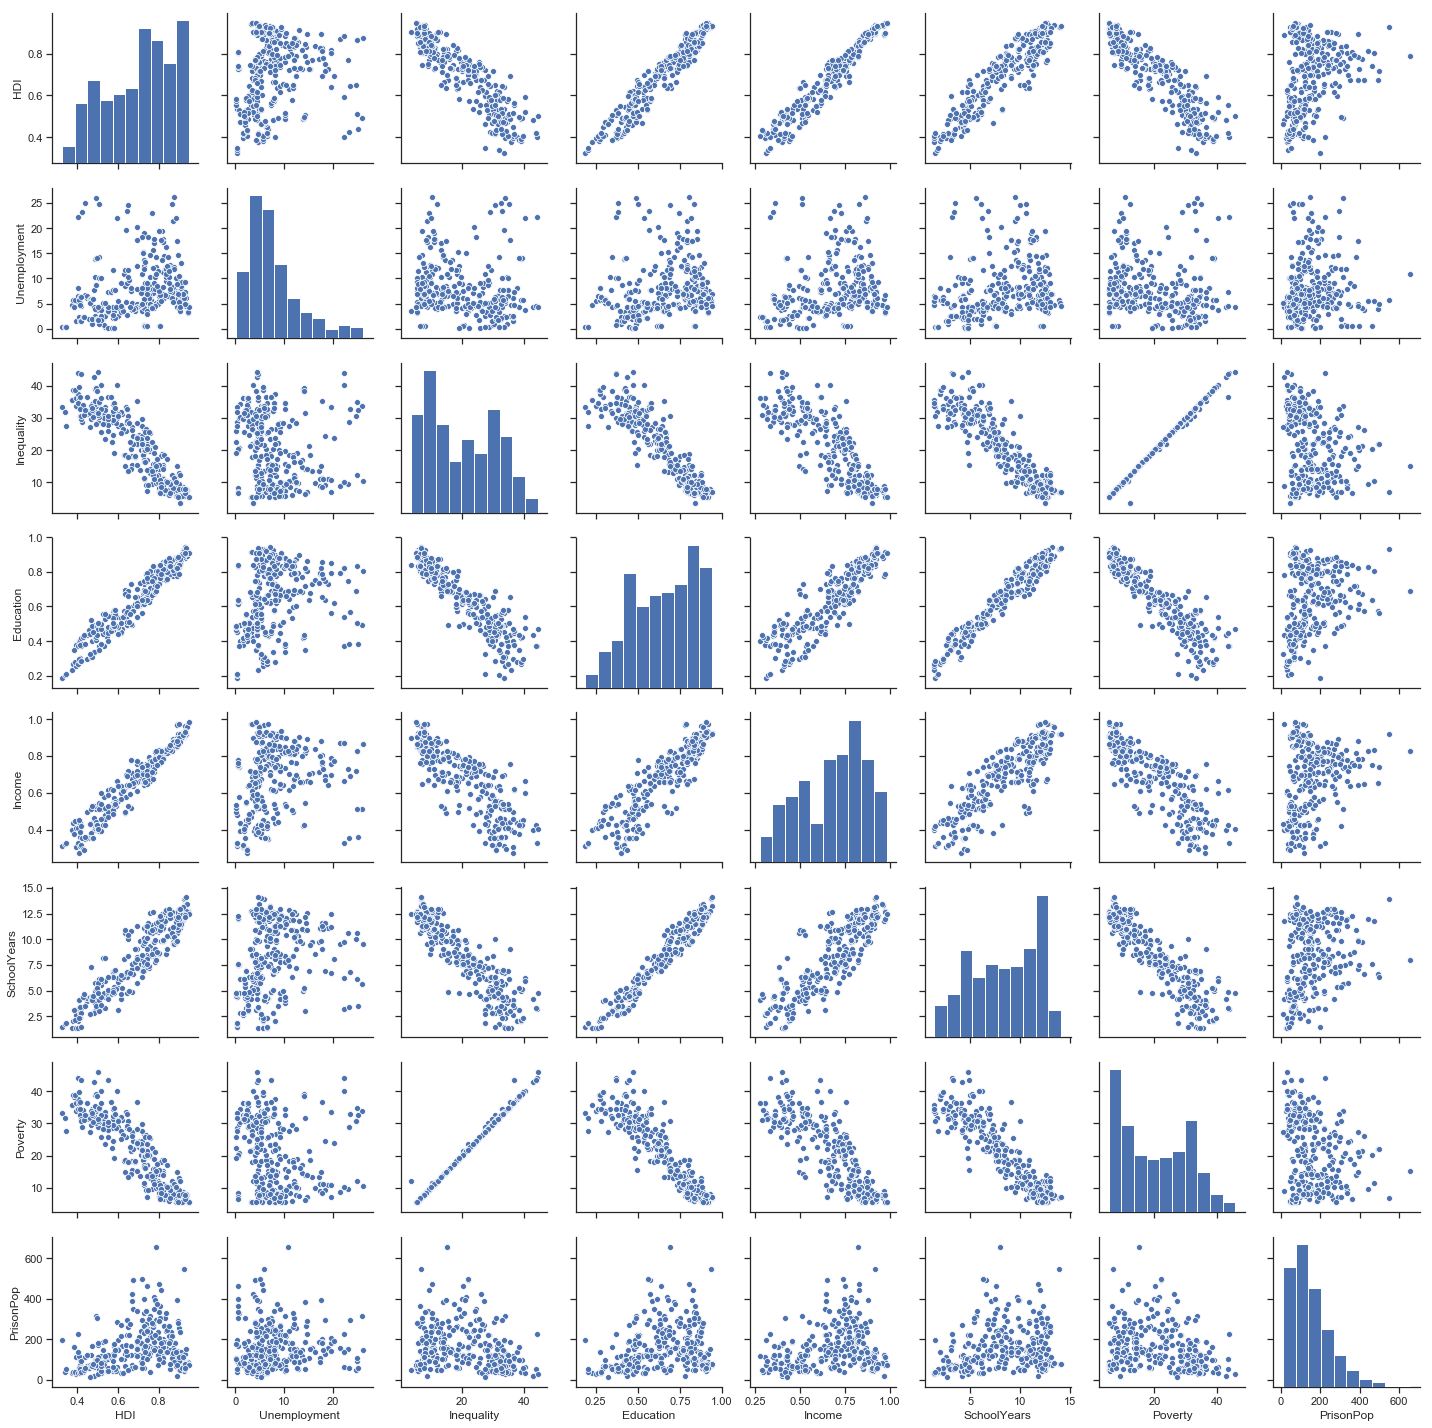

In [13]:
sns.set(style="ticks")
sns.pairplot(new_data_frame)

In [14]:
def cross_validate(regr, dataframe, features, predict):
    X = dataframe[features]
    y = dataframe[predict]
    N_FOLDS = 5
    
    scores = cross_val_score(regr, X, y, cv = N_FOLDS)
    predicted = cross_val_predict(regr, X, y, cv = N_FOLDS)
    sklearn.metrics.r2_score(y, predicted) 
    
    print ('Cross-validated scores:', scores)

    
def test_model(dataframe, features, predict):
    dfTrain, dfTest = train_test_split(dataframe, test_size=0.2)
        
    X_train = np.array(dfTrain[features])
    y_train = np.array(dfTrain[predict])
    
    X_test = np.array(dfTest[features])
    y_test = np.array(dfTest[predict])
    
    # Create linear regression object
    regr = sk.linear_model.LinearRegression(normalize=True)
    
    # Train the model using the training sets
    regr.fit(X_train, y_train)
    
    # Make predictions using the testing set
    y_pred = regr.predict(X_test)
    
    # The coefficients
    print('Coefficients:     ', regr.coef_)
    print('Intercept:        ', regr.intercept_)
    
    # The mean squared error (MSE)
    print('Mean squared error: %.2f' % mean_squared_error(y_test, y_pred))
    
    # Explained variance score: 1 is perfect prediction
    print('Variance score:     %.2f' % r2_score(y_test, y_pred))
    
    # R^2 (coefficient of determination) regression score function.
    # Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). 
    
    # A constant model that always predicts the expected value of y, disregarding the input features, 
    # would get a R^2 score of 0.0.
    
    # considering only the mean values of y_train
    print('Variance score (baseline): %.2f' % r2_score(y_test, [np.mean(y_train) for i in range(len(y_test))]))
    print('Ajusted R^2')
    SS_Residual = sum((y_test - y_pred)**2)
    SS_Total = sum((y_test - np.mean(y_test))**2)
    r_squared = 1 - (float(SS_Residual)) / SS_Total
    adjusted_r_squared = 1 - (1 - r_squared) * (len(y_test)-1) / (len(y_test)-X_test.shape[1]-1)
    print (r_squared, adjusted_r_squared)
    
    cross_validate(regr, dataframe, features, predict)
    

In [15]:
test_model(new_data_frame, [col for col in new_data_frame.columns if col != 'PrisonPop'], 'PrisonPop')

Coefficients:      [377.68058743  -0.96972118  14.44876788  97.07488866 -47.94886787
  -3.81700452 -11.16190967]
Intercept:         -161.22750067366383
Mean squared error: 9256.11
Variance score:     -0.05
Variance score (baseline): -0.03
Ajusted R^2
-0.05344151600575997 -0.19257530113859622
Cross-validated scores: [-0.09704477  0.06954318  0.00117327 -0.03681601  0.05790023]


In [16]:
test_model(new_data_frame, ['HDI', 'Education', 'Poverty'], 'PrisonPop')

Coefficients:      [245.06486534  18.07099463   1.80082547]
Intercept:         -60.096697748230184
Mean squared error: 8137.13
Variance score:     0.03
Variance score (baseline): -0.05
Ajusted R^2
0.030597393614817725 -0.020423796194928734
Cross-validated scores: [-0.0594784   0.0636375   0.06025109 -0.06182624  0.0626732 ]


In [17]:
test_model(new_data_frame, ['Unemployment', 'Inequality', 'Income', 'SchoolYears'], 'PrisonPop')

Coefficients:      [  0.80622837   2.10416118 132.07553475   6.55391612]
Intercept:         -42.32141226034696
Mean squared error: 13523.52
Variance score:     -0.06
Variance score (baseline): -0.07
Ajusted R^2
-0.06021742890890769 -0.13594724525954383
Cross-validated scores: [-0.10206482  0.04414044  0.06686686 -0.06568573  0.04133913]


In [18]:
test_model(new_data_frame, ['Unemployment', 'Inequality', 'Income'], 'PrisonPop')

Coefficients:      [ -0.6699555    0.44647648 141.72216067]
Intercept:         53.98307183847638
Mean squared error: 14367.12
Variance score:     0.08
Variance score (baseline): -0.00
Ajusted R^2
0.08055437936550225 0.032162504595265595
Cross-validated scores: [-0.09910881  0.03940757  0.06137265 -0.07290994  0.05606738]
